In [2]:
import os
import pandas as pd
import matplotlib as mlt
import numpy as np
from scipy.stats import chi2_contingency

In [3]:
import lightgbm as lgb
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

from feature_selector import FeatureSelector

In [4]:
os.chdir('C:\\Users\\hp\\Desktop\\ml6#House_grade\\Dataset')

In [5]:
Bownership = pd.read_csv('Building_Ownership_Use.csv')
Bstructure = pd.read_csv('Building_Structure.csv')
itrain = pd.read_csv('train.csv')
itest = pd.read_csv('test.csv')

In [6]:
#Bdata.shape

In [7]:
#Bdata = pd.merge(Bownership, Bstructure, how='left', on=['building_id','district_id', 'vdcmun_id', 'ward_id'])

In [8]:
#Bdata_nan_rows = Bdata[Bdata.isnull().T.any().T]

In [9]:
display(itrain.isnull().sum())
itest.isnull().sum()

area_assesed                                 0
building_id                                  0
damage_grade                                 0
district_id                                  0
has_geotechnical_risk                        0
has_geotechnical_risk_fault_crack            0
has_geotechnical_risk_flood                  0
has_geotechnical_risk_land_settlement        0
has_geotechnical_risk_landslide              0
has_geotechnical_risk_liquefaction           0
has_geotechnical_risk_other                  0
has_geotechnical_risk_rock_fall              0
has_repair_started                       33417
vdcmun_id                                    0
dtype: int64

area_assesed                                 0
building_id                                  0
district_id                                  0
has_geotechnical_risk                        0
has_geotechnical_risk_fault_crack            0
has_geotechnical_risk_flood                  0
has_geotechnical_risk_land_settlement        0
has_geotechnical_risk_landslide              0
has_geotechnical_risk_liquefaction           0
has_geotechnical_risk_other                  0
has_geotechnical_risk_rock_fall              0
has_repair_started                       21922
vdcmun_id                                    0
dtype: int64

In [10]:
#zero_rows = Bdata[Bdata.count_families == 0]

In [11]:
total = len(itest)+len(itrain)
total

1052936

In [12]:
itest_nan_rows = itest[itest.isnull().T.any().T]
itest['area_assesed'].unique()

array(['Both', 'Building removed', 'Not able to inspect', 'Exterior',
       'Interior'], dtype=object)

In [13]:
num_col = ['count_floors_pre_eq', 'count_floors_post_eq', 'age_building', 'plinth_area_sq_ft', 'height_ft_pre_eq', 
           'height_ft_post_eq ']

In [14]:
itrain_1 = itrain.drop('damage_grade', axis=1)

In [15]:
#length of itrain data = 631761
itrain_len = len(itrain)

In [16]:
tt_data = pd.concat(objs=[itrain_1, itest], axis=0)

In [17]:
tt_01 = pd.merge(tt_data, Bownership, how='left', on=['building_id','district_id', 'vdcmun_id'])

In [18]:
tt_master = pd.merge(tt_01, Bstructure, how='left', on=['building_id','district_id', 'vdcmun_id', 'ward_id'])

In [19]:
tt_master['has_repair_started'] = tt_master['has_repair_started'].replace(np.nan, 2)

In [20]:
nan_row = tt_master[tt_master.isnull().T.any().T]
nan_row['count_families']

22706   NaN
Name: count_families, dtype: float64

In [21]:
tt_master['count_families'].unique()

array([ 2.,  1.,  0.,  4.,  3.,  5.,  9.,  6., nan,  7., 11.,  8.])

In [22]:
tt_master['count_families'].value_counts()

1.0     913095
0.0      84304
2.0      46244
3.0       7075
4.0       1618
5.0        413
6.0        128
7.0         33
8.0         16
9.0          8
11.0         1
Name: count_families, dtype: int64

In [23]:
#only one value in the'has_repair_started' is missing - so removing that row: 22706
#types = [2.,  1.,  0.,  4.,  3.,  5.,  9.,  6., 7., 11.,  8.]
#for i in range(0,len(types)):
 #   print(len(tt_master[tt_master.count_families == types[i]]))

In [24]:
#using skelearn_imputer, it impute with '1' as they are most frequent
from sklearn.preprocessing import Imputer
imp =Imputer(missing_values="NaN", strategy="median" )
tt_master["count_families"] = imp.fit_transform(tt_master[["count_families"]])

In [25]:
#pd.set_option('display.max_columns', None)
#tt_master.dtypes

In [26]:
#buildingId = tt_master['building_id']

In [27]:
tt_cat = tt_master.drop(['building_id'], axis =1)

In [28]:
one_hot_encoded = pd.get_dummies(tt_cat)

In [29]:
one_hot_encoded['building_id'] = tt_master['building_id']

In [30]:
one_hot_encoded.shape

(1052936, 93)

In [31]:
ftrain = one_hot_encoded[:itrain_len]
ftest = one_hot_encoded[itrain_len:]

In [78]:
rm_col = ['plan_configuration_H-shape', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 
            'has_secondary_use_health_post', 'plan_configuration_E-shape', 'plan_configuration_Building with Central Courtyard', 
            'has_secondary_use_school','plan_configuration_U-shape', 'has_secondary_use_institution', 'condition_post_eq_Covered by landslide', 
            'has_secondary_use_industry', 'plan_configuration_T-shape', 'plan_configuration_Others', 'plan_configuration_Multi-projected', 
            'has_geotechnical_risk_other','ground_floor_type_Other', 'has_geotechnical_risk_liquefaction', 'area_assesed_Interior', 
            'position_Attached-3 side', 'condition_post_eq_Damaged-Rubble Clear-New building built', 'legal_ownership_status_Other',
            'has_secondary_use_rental', 'plan_configuration_L-shape', 'legal_ownership_status_Institutional', 
            'area_assesed_Not able to inspect', 'has_geotechnical_risk_flood', 'foundation_type_Other', 'has_superstructure_rc_engineered', 
            'plan_configuration_Square', 'has_secondary_use_other', 'has_secondary_use_hotel', 'legal_ownership_status_Public', 
            'plan_configuration_Rectangular', 'has_superstructure_cement_mortar_stone', 'has_superstructure_other', 
            'position_Attached-2 side', 'foundation_type_Cement-Stone/Brick', 
            'has_geotechnical_risk_rock_fall', 'legal_ownership_status_Private', 'other_floor_type_RCC/RB/RBC','condition_post_eq_Damaged-Rubble clear', 
            'has_geotechnical_risk_fault_crack', 'land_surface_condition_Steep slope', 'ground_floor_type_Timber', 'condition_post_eq_Damaged-Rubble unclear', 
            'foundation_type_Bamboo/Timber', 'has_geotechnical_risk_landslide', 'has_geotechnical_risk_land_settlement', 'roof_type_RCC/RB/RBC', 
            'has_superstructure_stone_flag', 'has_secondary_use_agriculture', 'position_Attached-1 side', 'has_superstructure_mud_mortar_brick', 
            'has_superstructure_rc_non_engineered', 'has_secondary_use', 'foundation_type_RC', 'ground_floor_type_Brick/Stone', 
            'land_surface_condition_Moderate slope', 'has_superstructure_adobe_mud', 'has_superstructure_bamboo',
            'building_id' ]

In [86]:
#!pip install -U imbalanced-learn
dump_col = rm_col[0:40]
dump_col.append('building_id')

In [94]:
damage_predictors = ftrain.drop(dump_col, axis = 1)
var_target = itrain['damage_grade']

In [96]:
from collections import Counter
Counter(var_target).items()

dict_items([('Grade 4', 152244), ('Grade 2', 85084), ('Grade 1', 61320), ('Grade 5', 210825), ('Grade 3', 122288)])

In [37]:
itrain['damage_grade'].value_counts()

Grade 5    210825
Grade 4    152244
Grade 3    122288
Grade 2     85084
Grade 1     61320
Name: damage_grade, dtype: int64

In [ ]:
#fs = FeatureSelector(data = damage_predictors, labels = var_target)

In [98]:
#fs.record_collinear
display(test_set.shape)
damage_predictors.shape

(421175, 52)

(631761, 52)

In [ ]:
#train_set.to_csv('train_set.csv', index = False)
#ftest.to_csv('test_set.csv', index = False)

In [ ]:
#df = pd.read_csv('test_set.csv')

In [ ]:
from collections import Counter
def get_class_weights(y, smooth_factor=0):
    """
    Returns the weights for each class based on the frequencies of the samples
    :param smooth_factor: factor that smooths extremely uneven weights
    :param y: list of true labels (the labels must be hashable)
    :return: dictionary with the weight for each class
    """
    counter = Counter(y)

    if smooth_factor > 0:
        p = max(counter.values()) * smooth_factor
        for k in counter.keys():
            counter[k] += p

    majority = max(counter.values())

    return {cls: float(majority) / count for cls, count in counter.items()}

In [ ]:
class_weights = get_class_weights(var_target)
class_weights

In [39]:
#importing packages from sk learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

#FUNCTION for Train & Validation set
X_train, X_test, y_train, y_test = train_test_split(damage_predictors, var_target, train_size=0.7, test_size=0.3, random_state=0)

In [72]:
model = RandomForestClassifier(n_estimators = 699, max_features = '25', min_samples_leaf = 3, min_samples_split = 11, n_jobs = -1,
                              class_weight = {'Grade 1': 3.4381115459882583, 'Grade 2': 2.47784542334634, 
                                              'Grade 3': 1.7240039905796154,'Grade 4': 1.3847836367935682,'Grade 5': 1.0})
model.fit(X_train, y_train)
predicted_val = model.predict(X_test)
display(predicted_val)

array(['Grade 4', 'Grade 3', 'Grade 3', ..., 'Grade 1', 'Grade 5',
       'Grade 5'], dtype=object)

In [55]:
#clf_probs = model.predict_proba(X_test)
#print((clf_probs[:,3] > 0.5).astype(int))

In [73]:
from sklearn.metrics import accuracy_score
pscore = accuracy_score(y_test, predicted_val)
print(pscore)

0.7649225184536403


In [74]:
from sklearn.metrics import f1_score
f1_score(y_test, predicted_val, average='weighted')

0.7668124282458401

In [58]:
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_test, predicted_val)

In [59]:
SeeCM = pd.crosstab(y_test, predicted_val)
SeeCM

col_0,Grade 1,Grade 2,Grade 3,Grade 4,Grade 5
damage_grade,,,,,
Grade 1,16230,1741,211,45,0
Grade 2,959,16327,6054,2006,2
Grade 3,306,9028,18418,8980,10
Grade 4,37,2684,8565,34358,53
Grade 5,4,98,286,2580,60547


In [102]:
#for name, importance in zip(X_train.columns, model.feature_importances_): 
#   print(name, "=", importance)
#feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
#feat_importances.nlargest(4).plot(kind='barh')


district_id = 0.01021309670805091
has_geotechnical_risk = 0.002735942773674494
has_geotechnical_risk_fault_crack = 0.0009128250510047413
has_geotechnical_risk_flood = 0.00026154848553002326
has_geotechnical_risk_land_settlement = 0.0012095580707565227
has_geotechnical_risk_landslide = 0.001412675042236027
has_geotechnical_risk_liquefaction = 9.384361394657121e-05
has_geotechnical_risk_other = 1.7750886298928432e-05
has_geotechnical_risk_rock_fall = 0.000817624485911062
has_repair_started = 0.0766596922857362
vdcmun_id = 0.04661090690456459
ward_id = 0.07365705426846134
count_families = 0.0045855478304934775
has_secondary_use = 0.002639229683661319
has_secondary_use_agriculture = 0.0018414836014074296
has_secondary_use_hotel = 0.0007954006506430878
has_secondary_use_rental = 0.00019820669086662932
has_secondary_use_institution = 5.9385194317898665e-06
has_secondary_use_school = 1.4964711620219256e-06
has_secondary_use_industry = 7.676253215766047e-06
has_secondary_use_health_post = 0.0


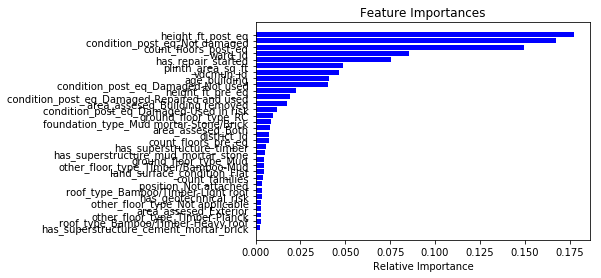

In [53]:
>>> features = X_train.columns
>>> importances = model.feature_importances_
>>> indices = np.argsort(importances)
col_names = []
for i in indices:
    n = features[i]
    col_names.append(n)

>>> plt.title('Feature Importances')
>>> plt.barh(range(len(indices)), importances[indices], color='b', align='center')
>>> plt.yticks(range(len(indices)), [features[i] for i in indices])
>>> plt.xlabel('Relative Importance')
>>> plt.show()

In [99]:
test_set = ftest.drop(dump_col, axis = 1)

In [100]:
#n_estimators = 599,max_features = 34,min_samples_leaf = 3,min_samples_split=11,class_weight = 'balanced_subsample'(77.4,74.4)
#n=799, 77.25 (All)
#n=999, 77.22 
#n_estimators = 599, max_features = 43, min_samples_leaf = 5, min_samples_split=16, n_jobs = -1, 77.17
#n_estimators = 599, max_features = 34, min_samples_leaf = 7, min_samples_split=25, n_jobs = -1, 77.03 (72 features)
# n_estimators = 999, max_features = 34, min_samples_leaf = 7, min_samples_split=16, n_jobs = -1, 77.05 (52 features)
# n_estimators = 999, max_features = 25, min_samples_leaf = 3, min_samples_split=11, n_jobs = -1, 77.35 (52)
#n_estimators = 999, max_features = 16, min_samples_leaf = 3, min_samples_split=11, n_jobs = -1, 77.24 (32)
#n_estimators = 1299, max_features = 16, min_samples_leaf = 3, min_samples_split=13, n_jobs = -1, 77.17 (32)


trainModel = RandomForestClassifier(n_estimators = 599, max_features = 26, min_samples_leaf = 3, min_samples_split = 11, 
                                    n_jobs = -1, class_weight = 'balanced_subsample')
trainModel.fit(damage_predictors, var_target)
predictions = trainModel.predict(test_set)
display(predictions)

array(['Grade 2', 'Grade 5', 'Grade 5', ..., 'Grade 1', 'Grade 5',
       'Grade 5'], dtype=object)

In [101]:
submission = pd.DataFrame(ftest.building_id)
submission['damage_grade'] = predictions
submission

,building_id,damage_grade
631761,a3380c4f75,Grade 2
631762,a338a4e653,Grade 5
631763,a338a4e6b7,Grade 5
631764,a33a6eaa3a,Grade 3
631765,a33b073ff6,Grade 5
631766,6604e4896c6,Grade 3
631767,a33b07430f,Grade 3
631768,a33c386cf3,Grade 5
631769,a33c386ee7,Grade 3
631770,a33c38700f,Grade 4


In [102]:
submission.to_csv('hE_Ml6_sub03.csv', index = False)